Now we look at a misclassified image and compare it to a correctly classified image of the top predicted brand. Let's load the usual modules and set up Caffe. 

In [95]:
import os
import caffe
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# set the plotting parameters
plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# we'll use the GoogLeNet model we fine-tuned
caffe_root = '/home/rips_tc/caffe/'
caffe.set_mode_cpu()
net = caffe.Net(caffe_root + 'models/google_logonet/deploy.prototxt',
                caffe_root + 'models/google_logonet/logonet.caffemodel',
                caffe.TEST)
net.blobs['data'].reshape(1, 3, 224, 224)

# set the transformer to conform to ImageNet standard
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(caffe_root + 'data/logos/logos_mean_deploy.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # imagenet operates on [0,255]
transformer.set_channel_swap('data', (2,1,0))

#we'll want the labels later, so load them from text:
logo_labels = caffe_root + 'data/logos/index-brand.txt'
labels = np.loadtxt(logo_labels, str, delimiter=' ')

We'll also define some useful functions to classify images and make plots.

In [96]:
# return the top num_results of classification. default is num_results = 5
def top_results(image_src, num_results=5):
    net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(image_src))
    out = net.forward()
    plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))
    top_k = net.blobs['prob'].data[0].flatten().argsort()[-1:-(num_results+1):-1]
    print labels[top_k]

# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

Let's look at an image that is misclassified.

[['2' 'adidas']
 ['104' 'nestle']
 ['137' 'starbucks']
 ['42' 'fox']
 ['64' 'ibm']]


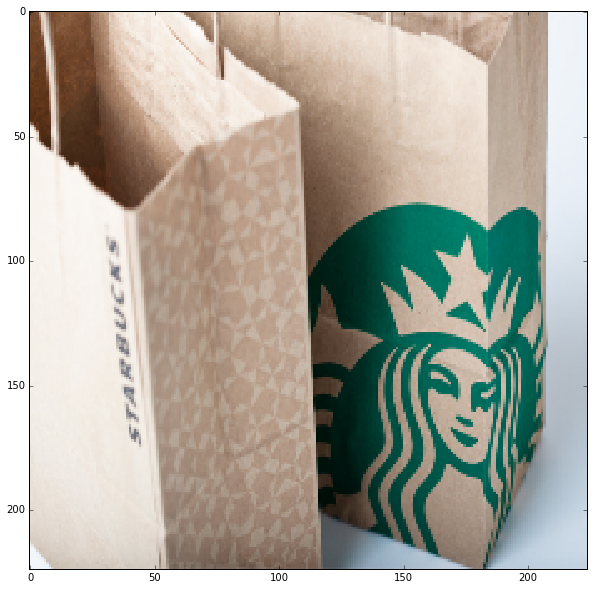

In [97]:
digital = caffe_root + 'data/logos/images/nvidia/image_299.jpg'
digital = '/home/rips_tc/Desktop/starbucks_follow_up_02.jpg'
top_results(digital)